In [1]:
import matplotlib.pyplot as plt
from operator import add

In [2]:
from ProbabilisticModel import *

## Read the dataset

In [3]:
class DatasetError(Exception): # Queries in LISA.QUE and LISARJ.NUM are ordered by increasing number from 1 to 35,
    pass                       # if this was not the case I raise an exception 


def read_test_queries():
    """ Reads from the 'LISA.QUE' file and returns a list of the test queries
    """
    queries = []
    with open('LISA_corpus/LISA.QUE', 'r') as reader:
        tmp = ""
        i = 1
        new_doc = True
        for line in reader:
            if new_doc:
                if i!=int(line):
                    raise DatasetError
                new_doc = False
                continue   # skip the line with the docID
            tmp += line
            if line.endswith("#\n"):  # we have reached the end of the document
                queries.append(tmp)
                tmp = ""
                new_doc = True
                i += 1
    return queries

In [4]:
def read_relevance_judgements():
    """ Reads from the 'LISARJ.NUM' file and returns a list of relevance judgements,
    whose i-th component is a list of the docIDs of documents relevant for the query
    corresponding to the i-th component of the list returned by read_test_queries()
    """
    relev = []
    with open("LISA_corpus/LISARJ.NUM", 'r') as reader:
        file = reader.read()
        i = 0
        numbers = [int(n) for n in file.split()]
        while i<len(numbers):
            if numbers[i]!=len(relev)+1:   # this is the ID of the query
                raise DatasetError
            i += 1
            how_many = numbers[i]  # how many documents are relevant for this query, i.e. how many numbers to read now
            i += 1
            relev.append(numbers[i:i+how_many])  # slice
            i += how_many
    return relev

## Functions for measuring effectiveness 

In [5]:
def eleven_points():
    """ Returns a list of 11 equally spaced points between 0 and 1, extremes included """
    points = []
    for i in range(11):
        points.append(i/10)
    return points

In [6]:
def evaluate_performance(retrieved_docs, judged_relev_docs, cut_list=True):
    """ Evaluates the effectiveness of a query answer by an IRsystem on the basis of true relevance judgements.
    The k-th component of the two returned lists is the precision and recall for the first k retrieved docs.
    The returned avg_prec value is the Average Precision (average of the precision values obtained after each
    relevant document is retrieved)
    
    Parameters
    ----------
    retrieved_docs    : a list of docIDs of ranked documents returned by the IR system (must be ordered)
    judged_relev_docs : a list (or a set, order is not important) of docIDs of the true relevant documents
    cut_list          : a boolean for deciding whether to cut the last part of the precision and recall arrays
                        after the last relevant document is retrieved, for performance reasons (it doesn't
                        affect the value of Average Precision nor the 11-point interpolated precision)
    """
    precision = []
    recall = []
    j = 0
    N = len(judged_relev_docs)   # total number of judged relevant docs
    avg_prec = 0  # average precision
    # "i" is the number of retrieved documents so far, "j" is the number of retrieved docs that are relevant
    for i, doc in enumerate(retrieved_docs, start=1):  # the first, second, third... document retrieved
        if doc in judged_relev_docs:  # the retrieved doc is relevant
            j += 1
            avg_prec += j/i
        precision.append(j/i)
        recall.append(j/N)
        if j==N and cut_list:  # this was the last relevant document, from this point onwards the precision
            break              # will always decrease and the recall will stay 1
    avg_prec /= N  # at this point N may be different than j because it may happen that not all relevant
                   # documents are retrieved
    return precision, recall, avg_prec

In [7]:
def plot_precision_recall_curve(precision, recall):
    """ Plots a plain precision-recall curve
    
    Parameters
    ----------
    precision, recall : two lists outputted by evaluate_performance()
    
    """
    plt.plot(recall, precision, '-o')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    ax = plt.gca()    # get current axis
    ax.spines['right'].set_visible(False)   # remove top and right border
    ax.spines['top'].set_visible(False)
    plt.xlabel("recall")
    plt.ylabel("precision")


In [8]:
def plot_interp_prec_recall_curve(precision, recall, extend_to_zero=True):
    """ Plots an interpolated precision-recall curve
    
    Parameters
    ----------
    precision, recall : two lists outputted by evaluate_performance()
    extend_to_zero    : a boolean for deciding whether to draw the curve till recall=0 even if
                        recall=0 was not a point of the original recall list
    """
    result_r = [recall[-1]]
    result_p = [0]

    for r, p in zip(reversed(recall), reversed(precision)):        
        if p>=result_p[-1]:
            if r==result_r[-1]:
                result_p[-1] = p    # overwrite
            else:
                result_r.append(r)  # add a new one
                result_p.append(p)
            
        
    if extend_to_zero:   # if you like that the curve starts from zero
        result_r.append(0)
        result_p.append(result_p[-1])
    
    result_r = list(reversed(result_r))
    result_p = list(reversed(result_p))
    plt.step(result_r, result_p, '.-')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    ax = plt.gca()    # get current axis
    ax.spines['right'].set_visible(False)   # remove top and right border
    ax.spines['top'].set_visible(False)
    plt.xlabel("recall")
    plt.ylabel("precision")

In [9]:
class WrongOutputDimension:
    pass

def compute_interp_prec(precision, recall, recall_levels):
    """ Computes the interpolated precision at the given recall levels
    
    Parameters
    ----------
    precision, recall : two lists outputted by evaluate_performance()
    recall_levels     : a list of recall values which MUST be ordered in ascending order,
                        for example eleven_points()
    """
    max_prec = 0
    result = []    # interpolated precision to be returned
            
    finished_loop = False
    recall_level = reversed(recall_levels)   # iterator over recall levels
    current_recall = next(recall_level)
    for r, p in zip(reversed(recall), reversed(precision)):
        while current_recall>r:
            result.append(max_prec)
            try:
                current_recall = next(recall_level)
            except StopIteration:
                finished_loop = True
                break
        if finished_loop:  # In Python there is no instruction to break two nested loops
            break
        max_prec = max(p, max_prec)
    
    # there could be some recall levels not iterated yet, if they are smaller than
    # the smallest recall of the input array
    if not finished_loop:   # if there are still some recall levels remaining
        while True:
            result.append(max_prec)
            try:
                next(recall_level)
            except StopIteration:
                break

    if len(result)!=len(recall_levels):   # something went wrong
        raise WrongOutputDimension   # wrong number of points in output list
    return list(reversed(result))

In [10]:
def compute_11point_interp_prec(precision, recall):
    """ Returns a list of the interpolated precision values at the 11 standard recall levels 
    
    Parameters
    ----------
    precision, recall : two lists outputted by evaluate_performance()
    """
    return compute_interp_prec(precision, recall, eleven_points())

In [11]:
def plot_interp_prec(precision, recall_levels):
    """ Plots the interpolated precision at the given recall levels 
    
    Parameters
    ----------
    precision     : interpolated precision at the input recall levels, which can be computed
                    with compute_interp_prec()
    recall_levels : list of recall values
    
    """
    plt.plot(recall_levels, precision, '.-')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    ax = plt.gca()    # get current axis
    ax.spines['right'].set_visible(False)   # remove top and right border
    ax.spines['top'].set_visible(False)
    plt.xlabel("recall")
    plt.ylabel("precision")

## Let's try the above functions

In [12]:
queries = read_test_queries()
relev = read_relevance_judgements()
corpus = read_LISA_corpus()
ir = IRsystem.from_pickle(corpus)

finished reading


In [13]:
myq = Query(queries[27], ir)
myq.update_results()
retrieved_docs = myq.get_results()
judged_relev_docs = relev[27]
precision, recall, avg_prec = evaluate_performance(retrieved_docs, judged_relev_docs)

In [14]:
print("Average precision: ", avg_prec)

Average precision:  0.371933871583977


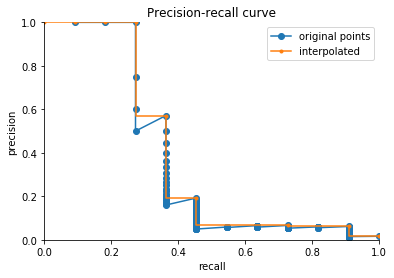

In [26]:
plot_precision_recall_curve(precision, recall)
plot_interp_prec_recall_curve(precision, recall)
plt.legend(["original points", "interpolated"])
plt.title("Precision-recall curve")
plt.show()

In [16]:
prec_at_11_pts = compute_interp_prec(precision, recall, eleven_points())
# table of 11-point interpolated precision
print("Precision\tRecall")
for r,p in zip(eleven_points(), prec_at_11_pts):
    print(r, "\t\t", "{:.3f}".format(p))

Precision	Recall
0.0 		 1.000
0.1 		 1.000
0.2 		 1.000
0.3 		 0.571
0.4 		 0.192
0.5 		 0.066
0.6 		 0.066
0.7 		 0.066
0.8 		 0.061
0.9 		 0.061
1.0 		 0.016


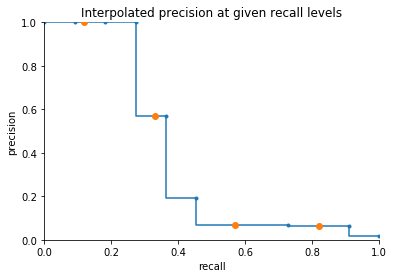

In [17]:
# the function compute_interp_prec() actually works for any custom recall levels
recall_levels = [0.12, 0.33, 0.57, 0.82]
interp_p = compute_interp_prec(precision, recall, recall_levels)
plot_interp_prec_recall_curve(precision, recall)
plt.plot(recall_levels, interp_p, '.', markersize=12)
plt.title("Interpolated precision at given recall levels")
plt.show()

## Now on the whole test queries set

In [18]:
def test_IRsystem(pseudo, plot):
    """ Prints precision-recall curves for each test query and returns Mean Average Precision
    and 11-point interpolated average precision for the set of test queries
    
    Parameters
    ----------
    pseudo : a boolean which is True if you want to do pseudo-relevance feedback
    plot   : a boolean which is True if you want to show the plots and display information for each query
    """
    MAP = 0  # Mean Average Precision
    avg_vector = [0 for i in range(11)]    # 11-point interpolated average precision
    i = 1
    for q, rel in zip(queries, relev):
        myq = Query(q, ir)
        myq.update_results()
        if pseudo:
            myq.iterative_pseudo_relevance()
        retrieved_docs = myq.get_results()
        judged_relev_docs = rel

        precision, recall, avg_prec = evaluate_performance(retrieved_docs, judged_relev_docs)
        MAP += avg_prec
        
        if plot:
            print("Query", i)
            print("average precision:", avg_prec)
            plot_precision_recall_curve(precision, recall)
            plot_interp_prec_recall_curve(precision, recall)
            plt.show()

        vector = compute_11point_interp_prec(precision, recall)
        avg_vector = list(map(add, avg_vector, vector))
        if len(vector)!=11:
            raise ValueError("error")
        i+=1

    MAP /= len(queries)
    avg_vector = [x/len(queries) for x in avg_vector]
    
    return MAP, avg_vector

Query 1
average precision: 1.0


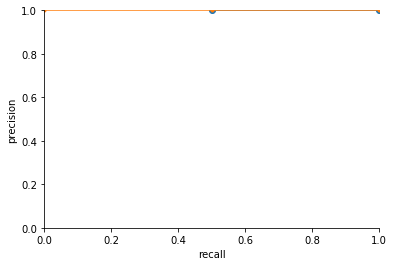

Query 2
average precision: 0.7


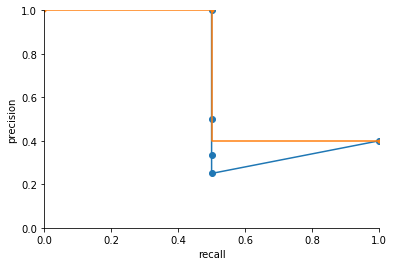

Query 3
average precision: 0.885


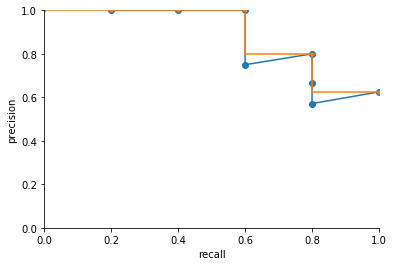

Query 4
average precision: 0.09462558433540115


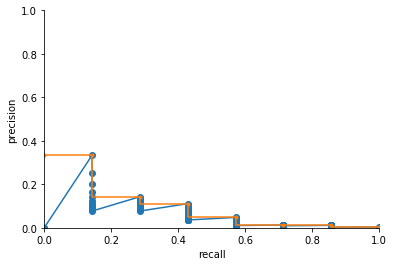

Query 5
average precision: 0.008333333333333333


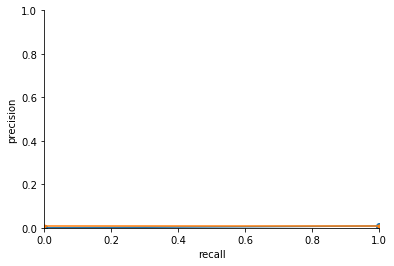

Query 6
average precision: 0.27614293466645096


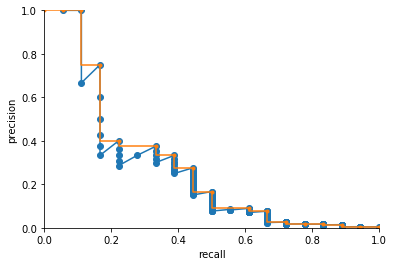

Query 7
average precision: 0.43437747906180013


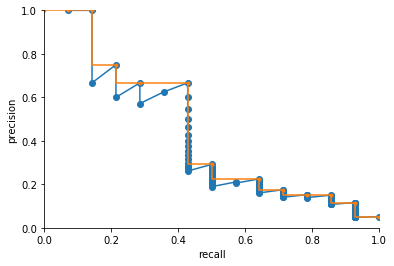

Query 8
average precision: 0.11482223643043142


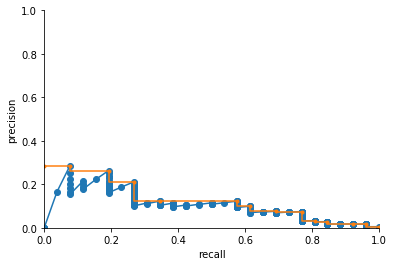

Query 9
average precision: 0.4429274282278797


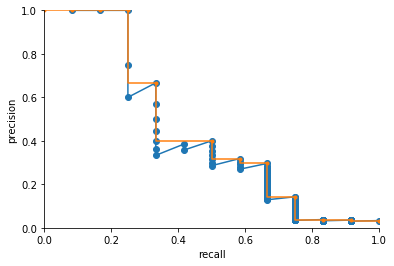

Query 10
average precision: 0.6138659379771895


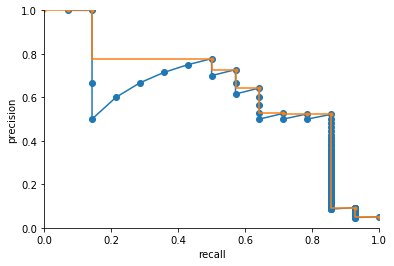

Query 11
average precision: 0.011111111111111112


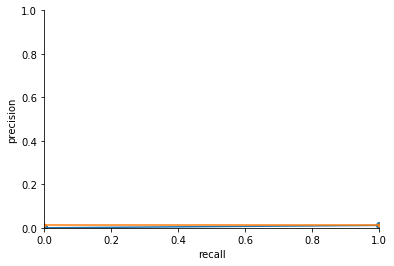

Query 12
average precision: 0.3344827586206897


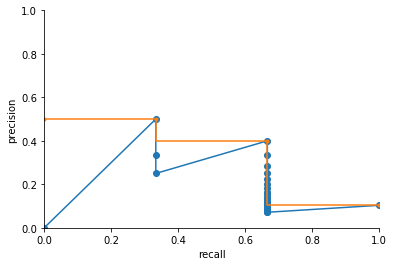

Query 13
average precision: 1.0


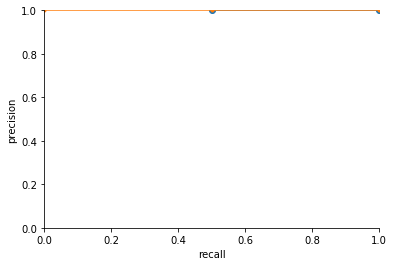

Query 14
average precision: 0.21404374700903758


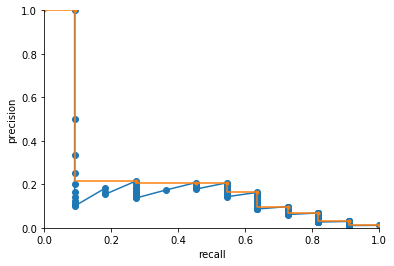

Query 15
average precision: 0.6236790178282918


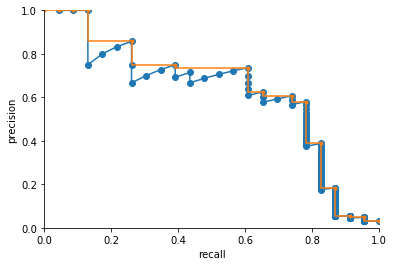

Query 16
average precision: 0.27878787878787875


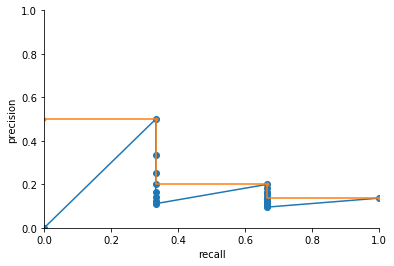

Query 17
average precision: 0.024974031772600214


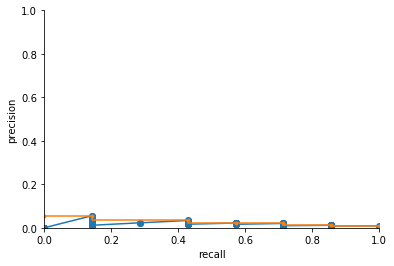

Query 18
average precision: 0.3400797242600833


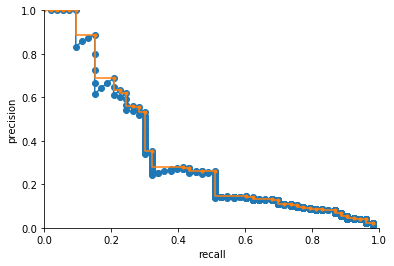

Query 19
average precision: 0.0678990535232653


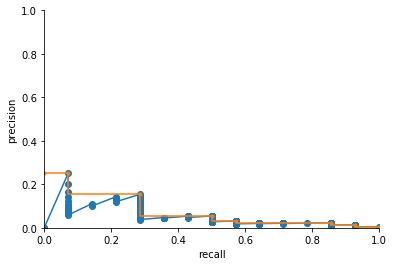

Query 20
average precision: 0.5502899877899877


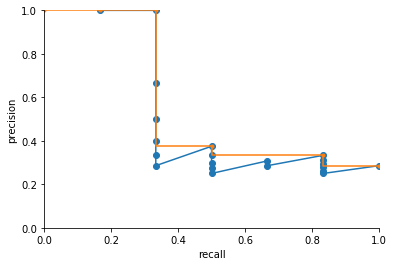

Query 21
average precision: 0.08029787629436619


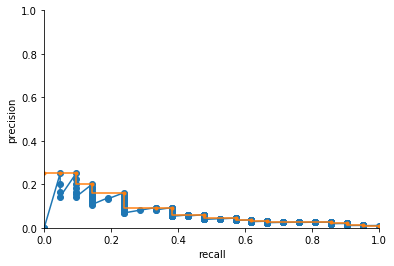

Query 22
average precision: 0.003676470588235294


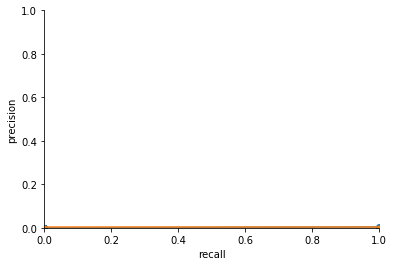

Query 23
average precision: 0.17084391064835047


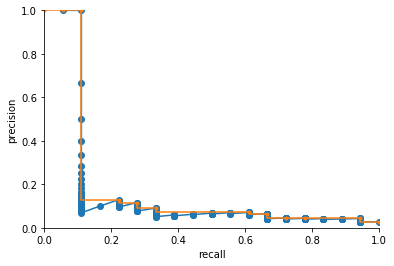

Query 24
average precision: 0.8347222222222221


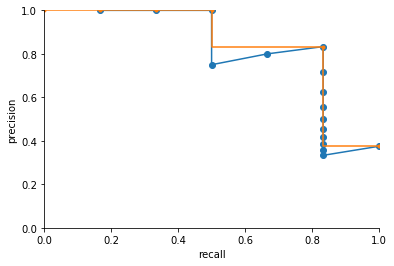

Query 25
average precision: 0.5277777777777778


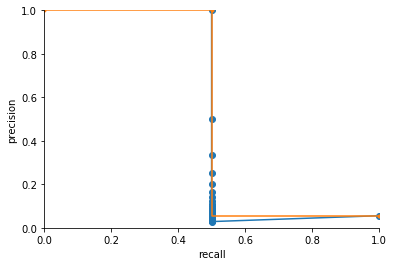

Query 26
average precision: 0.03314379697213587


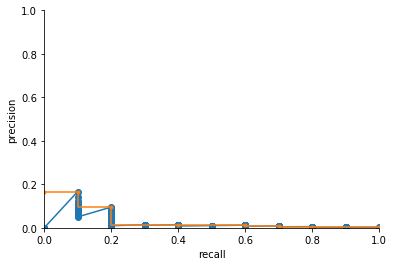

Query 27
average precision: 0.1151768262226599


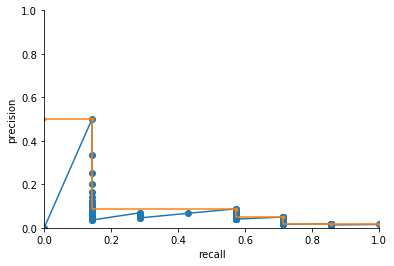

Query 28
average precision: 0.371933871583977


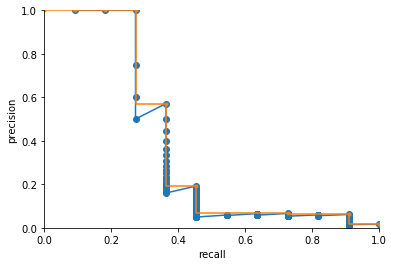

Query 29
average precision: 0.09507426731484664


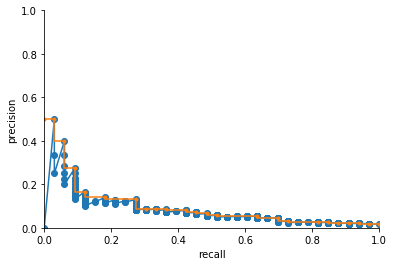

Query 30
average precision: 0.432060091887678


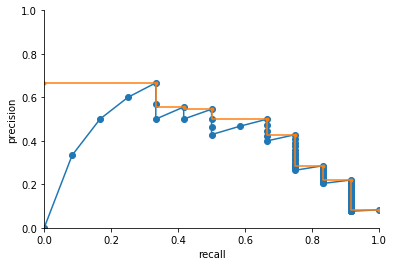

Query 31
average precision: 0.5099063268637305


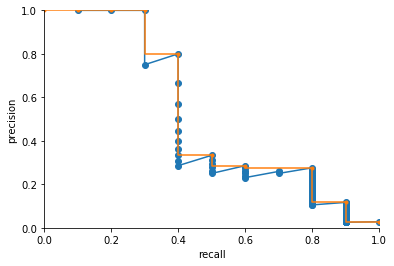

Query 32
average precision: 0.03801710522928669


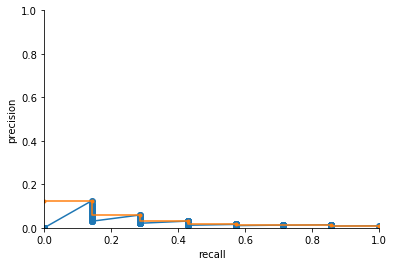

Query 33
average precision: 0.11490854501844867


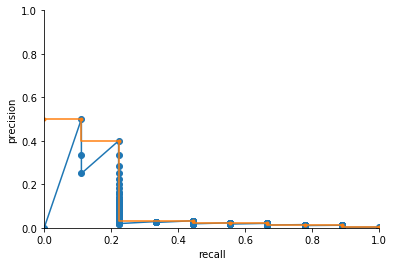

Query 34
average precision: 0.5


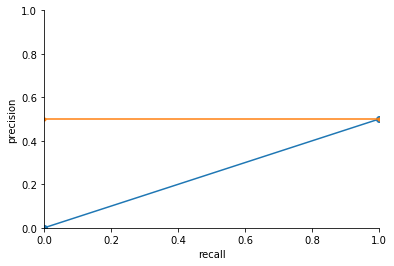

Query 35
average precision: 0.3327959352295636


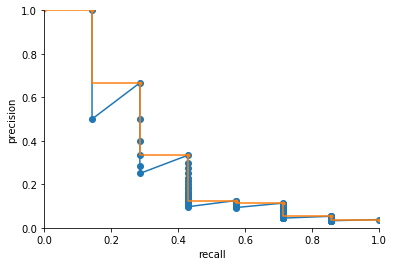

In [19]:
MAP, avg_vector = test_IRsystem(pseudo=False, plot=True)

In [20]:
MAP_pseudo, avg_vector_pseudo = test_IRsystem(pseudo=True, plot=False)

In [21]:
print("Mean Average Precision: ", MAP)
print("Mean Average Precision after pseudo-relevance feedback: ", MAP_pseudo)

Mean Average Precision:  0.34787935053110597
Mean Average Precision after pseudo-relevance feedback:  0.3695643145904044


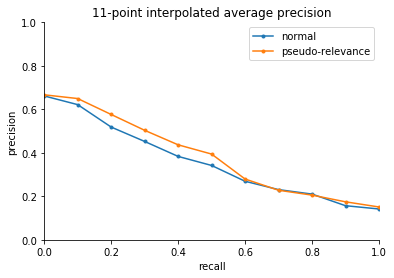

In [22]:
plot_interp_prec(avg_vector, eleven_points())
plot_interp_prec(avg_vector_pseudo, eleven_points())
plt.legend(["normal", "pseudo-relevance"])
plt.title("11-point interpolated average precision")
plt.show()

In [23]:
def assess_relevance_feedback(feedback):
    """ Assess the effectiveness of interactive relevance feedback. Run the function
    with feedback=False and then with feedback=True to see the gain in Mean Average Precision,
    computed excluding the document judged relevant (for fairness); the MAP is averaged over
    all the relevant documents for each query
    
    Parameters
    ----------
    feedback : a boolean for telling or not telling one relevant document to the IR system
    """
    MAP=0     # Mean Average Precision
    i=0
    for q, rel in zip(queries, relev):
        myq = Query(q, ir)
        myq.update_results()
        judged_relev_docs = rel
        if len(judged_relev_docs)<=1:   # exclude queries with only one relevant document
            continue
        i+=1

        mean_avg_prec=0                  # Average Precision, averaged across the choice of which document
        for doc in judged_relev_docs:    # in judged_relevant_docs to give as relevance feedback
            if feedback:
                myq.reset_feedback()
                myq.give_feedback([doc])
                myq.update_results()
            retrieved_docs = myq.get_results()
            filtered_retrieved_docs = [d for d in retrieved_docs if d!=doc]
            filtered_judged_relev_docs = [d for d in judged_relev_docs if d!=doc]
            precision, recall, avg_prec = evaluate_performance(filtered_retrieved_docs, filtered_judged_relev_docs)
            mean_avg_prec += avg_prec
        mean_avg_prec /= len(judged_relev_docs)
        MAP += mean_avg_prec

    MAP /= i    # "i" is the number of queries with at least one relevant doc
    return MAP

In [24]:
MAP_before = assess_relevance_feedback(False)
MAP_after = assess_relevance_feedback(True)

In [25]:
print("MAP before relevance feedback: ", MAP_before)
print("MAP after relevance feedback: ", MAP_after)

MAP before relevance feedback:  0.36486917602891494
MAP after relevance feedback:  0.383375587731909
